<a href="https://colab.research.google.com/github/DanielaTola/SigatokaNegraResNet-50/blob/main/50_epocas_segmentadosbordes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from PIL import Image
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_epochs = 50
learning_rate = 0.001
batch_size = 32

In [ ]:
# Cargar modelo pre-entrenado y congelar parámetros de capas iniciales
model = models.resnet50(pretrained=True)

# Congelar todas las capas excepto la capa fc
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

# Ajustar parámetros para que solo la capa fc sea entrenable
for param in model.fc.parameters():
    param.requires_grad = True


# Definir función de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
data_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Train-ResNet-50/TrainCompletoSegmentadoBordes/Train",transform=data_transform) 
test_dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Train-ResNet-50/TrainCompletoSegmentadoBordes/Test",transform=data_transform)

print(train_dataset.classes)
print(test_dataset.classes)
# Crear dataloaders para entrenamiento y pruebas
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


['Etapa1', 'Etapa2', 'Etapa3', 'Etapa4']
['Etapa1', 'Etapa2', 'Etapa3', 'Etapa4']


Epoch [1/50], Step [39/39], Loss: 1.3633, Accuracy: 0.2814
Epoch [1], Accuracy_testing: 0.2814
Mejor entrenamiento:  0.28135048231511256
[[ 9 11  9 26]
 [ 8 18  4 25]
 [10 19  8 18]
 [10 18  7 20]]

Reporte de clasificación:
              precision    recall  f1-score   support

      Etapa1       0.24      0.16      0.20        55
      Etapa2       0.27      0.33      0.30        55
      Etapa3       0.29      0.15      0.19        55
      Etapa4       0.22      0.36      0.28        55

    accuracy                           0.25       220
   macro avg       0.26      0.25      0.24       220
weighted avg       0.26      0.25      0.24       220

Epoch [2/50], Step [39/39], Loss: 1.2703, Accuracy: 0.4751
Epoch [2], Accuracy_testing: 0.4751
Mejor entrenamiento:  0.47508038585209006
[[13 10 15 17]
 [11 14 14 16]
 [15  8 21 11]
 [15 11 14 15]]

Reporte de clasificación:
              precision    recall  f1-score   support

      Etapa1       0.24      0.24      0.24        55
      

KeyboardInterrupt: ignored

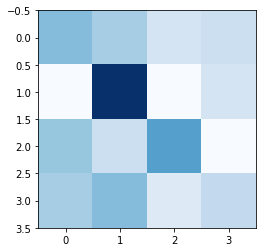

In [ ]:
# Entrenar la red
loss_list = []
acc_list = []
best_acc = 0

for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Pasar datos a través de la red
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = correct / total
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        acc_list.append(correct / total)

        # Realizar un paso de optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) == len(train_loader):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(), acc))
    y_true = []
    y_pred = []
    # Evaluar la red en el conjunto de pruebas
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    acc = correct / total
    print('Epoch [{}], Accuracy_testing: {:.4f}'.format(epoch+1,  acc))

    if acc > best_acc:
        best_acc = acc
        print("Mejor entrenamiento: ",best_acc)
        torch.save(model, 'best_model.pt') 
        cm = confusion_matrix(y_true, y_pred)
        class_name=['Etapa1', 'Etapa2', 'Etapa3', 'Etapa4']
        report = classification_report(y_true, y_pred, target_names=class_name)
        print(cm)
        print('\nReporte de clasificación:')
        print(report)
        plt.imshow(cm, cmap=plt.cm.Blues)
        plt.savefig('/content/drive/MyDrive/Train-ResNet-50/GraficosM/matriz_confusion-2023-03-4-{}.png' .format(epoch+1))

Matriz de confusión:
[[50  2  1  2]
 [ 1 53  0  1]
 [ 9 11 34  1]
 [ 5  0  3 47]]

Reporte de clasificación:
              precision    recall  f1-score   support

      Etapa1       0.77      0.91      0.83        55
      Etapa2       0.80      0.96      0.88        55
      Etapa3       0.89      0.62      0.73        55
      Etapa4       0.92      0.85      0.89        55

    accuracy                           0.84       220
   macro avg       0.85      0.84      0.83       220
weighted avg       0.85      0.84      0.83       220



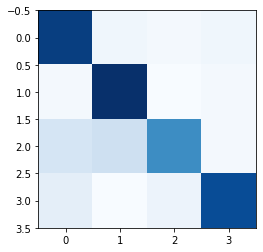

In [ ]:
model = torch.load('best_model.pt')

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

cm = confusion_matrix(y_true, y_pred)
class_name=['Etapa1', 'Etapa2', 'Etapa3', 'Etapa4']
report = classification_report(y_true, y_pred, target_names=class_name)

print('Matriz de confusión:')
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)
print('\nReporte de clasificación:')
print(report)
plt.savefig('/content/drive/MyDrive/Train-ResNet-50/GraficosM/matriz_confusion_best_model.png')


In [ ]:
accuracy = np.trace(cm) / np.sum(cm)
print('Accuracy: ', accuracy)

Accuracy:  0.8363636363636363


In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_true, y_pred)
print("Precisión: {:.2f}%".format(accuracy * 100))

Precisión: 83.64%


In [ ]:
directory = "/content/drive/MyDrive/Train-ResNet-50/Inferencias"

model = torch.load("best_model.pt")

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

for filename in os.listdir(directory):
  if filename.endswith(".jpg"):
  
    img = Image.open(os.path.join(directory, filename))
    image = data_transform(img).unsqueeze(0)
    model.eval()
    with torch.no_grad():
      output = model(image)
      probs = torch.softmax(output, dim=1)
      pred_class = torch.argmax(probs, dim=1).item()
      max_prob = torch.max(probs).item()

      if max_prob >= 0.92:
        print(f"La imagen {filename} es de la clase {pred_class+1} con probabilidad {max_prob:.2f}")
      else:
        print(f"No se puede clasificar la imagen {filename} con suficiente confianza.")


No se puede clasificar la imagen ETAPA 1.jpg con suficiente confianza.
No se puede clasificar la imagen Etapa 2 (5).jpg con suficiente confianza.
No se puede clasificar la imagen Etapa 3.jpg con suficiente confianza.
No se puede clasificar la imagen Etapa 3 (3).jpg con suficiente confianza.
La imagen IMG-ETAPA-02-3.jpg es de la clase 1 con probabilidad 0.96
La imagen descarga.jpg es de la clase 1 con probabilidad 0.96
No se puede clasificar la imagen descarga 10.jpg con suficiente confianza.
No se puede clasificar la imagen perro.jpg con suficiente confianza.
No se puede clasificar la imagen perro2.jpg con suficiente confianza.
No se puede clasificar la imagen lechuga.jpg con suficiente confianza.
No se puede clasificar la imagen lechuga_2.jpg con suficiente confianza.
No se puede clasificar la imagen flores.jpg con suficiente confianza.
La imagen floresb.jpg es de la clase 2 con probabilidad 1.00
La imagen OtroperroCesped.jpg es de la clase 2 con probabilidad 0.92
No se puede clasific

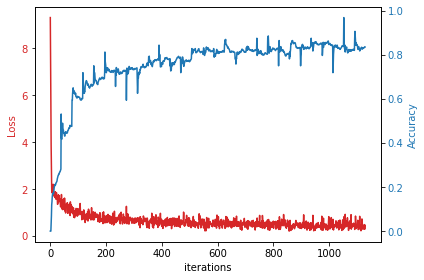

<Figure size 432x288 with 0 Axes>

In [ ]:
# Crear gráfico
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/fn-gafico_de_aprendizaje.png')